(880, 587)


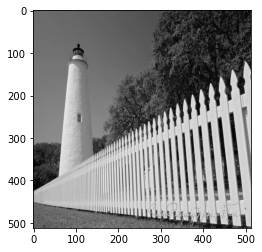

In [151]:
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps

img = Image.open("Lighthouse.JPG")
print(img.size)
img = img.resize((512, 512), Image.ANTIALIAS)
img = ImageOps.grayscale(img)
img = np.array(img)
plt.imshow(img, cmap="gray")

In [164]:
def upsample(img):
    h, w= img.shape
    new_img = np.zeros((h * 2, w * 2))
    new_img[::2, ::2] = img
    new_img[1::2, ::2] = img
    new_img[::2, 1::2] = img
    new_img[1::2, 1::2] = img
    return new_img

(266, 400, 3)


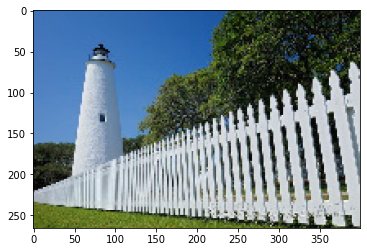

In [144]:
small_img = image.imread("Lighthouse_small.jpg")
large_img = upsample(small_img)
large_img[large_img > 255] = 255
large_img = large_img.astype(np.uint8)
plt.imshow(large_img)
print(large_img.shape)

In [169]:
from scipy.signal import convolve2d

def get_pyramid(img, kernel, levels):
    layers = [img]
    band_passes = []
    for i in range(levels):
        decimated = np.zeros(layers[-1].shape)
        
        decimated[:,:] = convolve2d(layers[-1][:,:], kernel, 'same', 'symm')
        decimated = decimated[::2, ::2]
        
        band_pass = layers[-1] - upsample(decimated)

        #decimated[decimated > 255] = 255
        #decimated[decimated < 0] = 0
        #decimated = decimated.astype(np.uint8)
        
        layers.append(decimated)
        band_passes.append(band_pass)
    return layers, band_passes

In [154]:
def reconstruct(gauss, band_passes):
    curr_img = gauss
    for i in range(len(band_passes)):
        curr_img = upsample(curr_img) + band_passes[-1 - i]
    return curr_img

In [14]:
l = np.array([1, 4, 6, 4, 1]) / 16.
binomial = np.transpose([l]) @ [l]
print(binomial)
print(np.sum(binomial))

[[0.00390625 0.015625   0.0234375  0.015625   0.00390625]
 [0.015625   0.0625     0.09375    0.0625     0.015625  ]
 [0.0234375  0.09375    0.140625   0.09375    0.0234375 ]
 [0.015625   0.0625     0.09375    0.0625     0.015625  ]
 [0.00390625 0.015625   0.0234375  0.015625   0.00390625]]
1.0


In [35]:
block = np.ones((2, 2)) / 4
print(block)

[[0.25 0.25]
 [0.25 0.25]]


In [38]:
single = np.ones((1,1))

In [67]:
S = 0.5

step = 1
vals = np.arange(-9, 10, step)
xv, yv = np.meshgrid(vals, vals)
sinc = S**2 * np.sinc(S * xv) * np.sinc(S * yv)
total = np.sum(sinc)
sinc /= total
print(total * step**2)

1.0640479198510429


In [76]:
shifted_img = np.zeros(img.shape)
shifted_img[2:, 2:, :] = img[:-2, :-2, :]
shifted_img = shifted_img.astype(np.uint8)
print(shifted_img.dtype, shifted_img[1, 1])

uint8 [0 0 0]


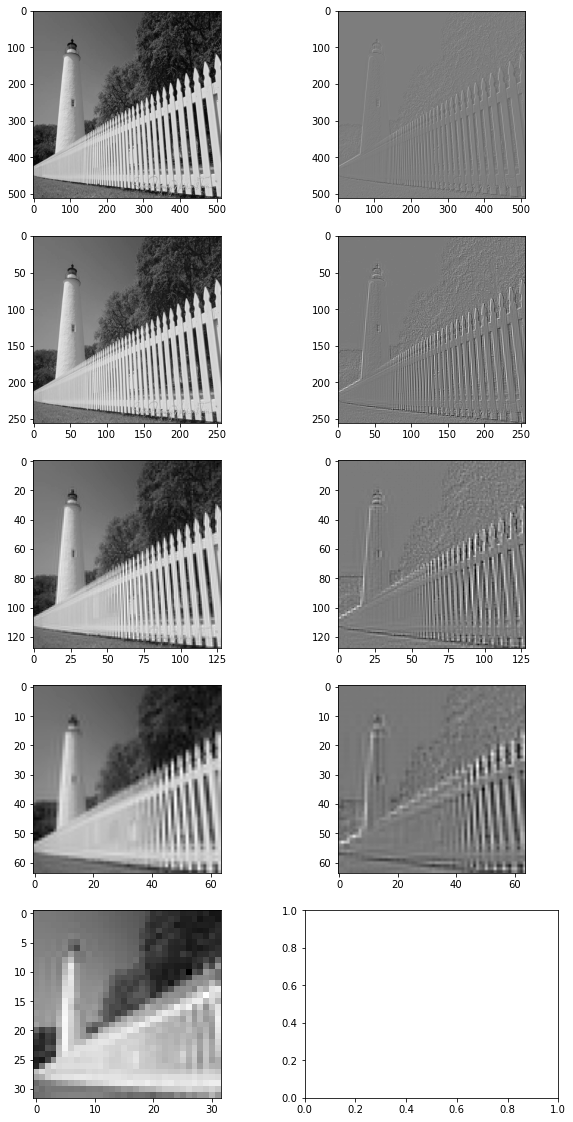

In [170]:
L = 4
pyramid, band_passes = get_pyramid(img, sinc, L)

fig, axs = plt.subplots(L + 1, 2, figsize=(10, 20))
for i in range(L + 1):
    axs[i, 0].imshow(pyramid[i], cmap="gray")
    if i < L:
        axs[i, 1].imshow(band_passes[i], cmap="gray")

(512, 512)


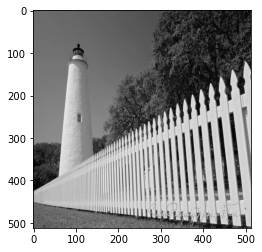

In [171]:
restored = reconstruct(pyramid[-1], band_passes)
print(restored.shape)
plt.imshow(restored, cmap="gray")